In [1]:
import pandas as pd
import numpy as np
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image, ImageOps, ImageFilter
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
%matplotlib inline
np.random.seed(123)
import os

In [62]:
# Getting mirror images for normal to deal with class imbalance
"""
for filename in os.listdir('chest_xray/train/NORMAL'):
    if filename.endswith('.jpeg'):
        im = Image.open(os.path.join('chest_xray/train/NORMAL/', filename))
        im_mirror = ImageOps.mirror(im)
        im_mirror.save('chest_xray/train/NORMAL/mirror_'+filename)
    else:
        continue
"""

In [69]:
"""
i = 0
for filename in os.listdir('chest_xray/train/NORMAL'):
    if filename.endswith('.jpeg'):
        im = Image.open(os.path.join('chest_xray/train/NORMAL/', filename))
        im=im.convert("RGB")
        if i % 2 == 0:
            new = im.filter(ImageFilter.GaussianBlur)
        else:
            new = im.filter(ImageFilter.UnsharpMask)
        new.save('chest_xray/train/NORMAL/augment_'+filename)
        i += 1
    else:
        continue
    if i  == 1185:
        break
"""

In [2]:
train = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory = 'chest_xray/train',
        class_mode = 'binary',
        target_size = (128, 128),
        batch_size = 7772) 

Found 7772 images belonging to 2 classes.


In [3]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory = 'chest_xray/test',
        class_mode = 'binary',
        target_size = (128, 128),
        batch_size = 624) 

Found 624 images belonging to 2 classes.


In [4]:
# Spliting images and labels
test_images, test_labels = next(test)
train_images, train_labels = next(train)


In [5]:
test_labels = np.reshape(test_labels, (len(test_labels),1)). astype(int)
train_labels = np.reshape(train_labels, (len(train_labels),1)). astype(int)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [8]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [10]:
cnn1 = cnn.fit(x_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(x_val, y_val),
                      workers = -1)

Epoch 1/5
125/125 [==============================] - 165s 1s/step - loss: 0.6081 - acc: 0.6868 - val_loss: 0.8296 - val_acc: 0.4920
Epoch 2/5
125/125 [==============================] - 167s 1s/step - loss: 0.3948 - acc: 0.8287 - val_loss: 0.7152 - val_acc: 0.6386
Epoch 3/5
125/125 [==============================] - 244s 2s/step - loss: 0.2527 - acc: 0.9006 - val_loss: 0.1764 - val_acc: 0.9479
Epoch 4/5
125/125 [==============================] - 150s 1s/step - loss: 0.1842 - acc: 0.9286 - val_loss: 0.1258 - val_acc: 0.9550
Epoch 5/5
125/125 [==============================] - 179s 1s/step - loss: 0.1645 - acc: 0.9347 - val_loss: 0.1364 - val_acc: 0.9473


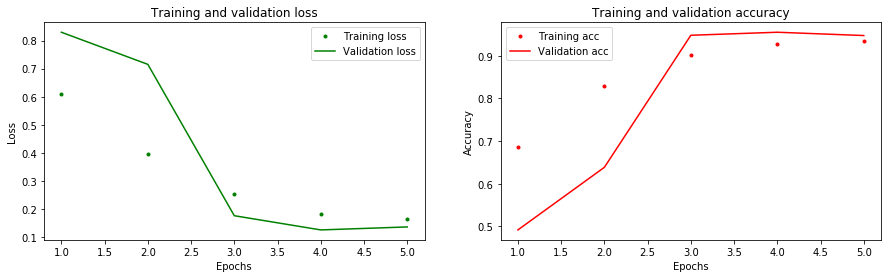

In [11]:
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
results_train = cnn.evaluate(x_train, y_train)
results_test = cnn.evaluate(test_images, test_labels)
print(results_train, results_test)

20/20 [==============================] - 4s 185ms/step - loss: 0.8168 - acc: 0.7292
[0.1728186160326004, 0.929065465927124] [0.81678307056427, 0.7291666865348816]


In [16]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(128, 128))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    return predict


array([[0.5948161]], dtype=float32)

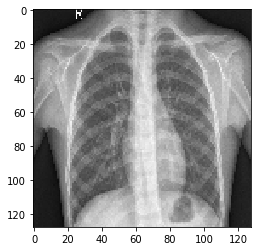

In [17]:
predictoneimage_cnn(cnn, 'chest_xray/test/NORMAL/IM-0001-0001.jpeg')

array([[0.9993681]], dtype=float32)

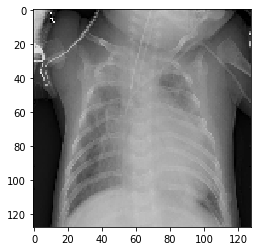

In [18]:
predictoneimage_cnn(cnn, 'chest_xray/test/PNEUMONIA/person1_virus_6.jpeg')

In [19]:
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

In [20]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
new_model = models.Sequential()
new_model.add(imagenet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(1024,activation='relu'))
new_model.add(Dense(1024,activation='relu')) #dense layer 2
new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

In [38]:
for i,layer in enumerate(imagenet.layers):
    print(i,layer.name, layer.trainable)

0 input_1 True
1 conv2d_2 True
2 batch_normalization True
3 activation True
4 conv2d_3 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_4 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d_2 True
11 conv2d_5 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_6 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_3 True
18 conv2d_10 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_8 True
22 conv2d_11 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_7 True
29 conv2d_9 True
30 conv2d_12 True
31 conv2d_13 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_17 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_15 T

In [ ]:
new_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
nm = new_model.fit(x_train,
             y_train,
             epochs=5,
             batch_size=50,
             validation_data = (x_val, y_val),
                  workers = -1)

Epoch 1/5
 71/125 [================>.............] - ETA: 5:06 - loss: 0.1854 - accuracy: 0.9482